In [139]:
import os
import re
import numpy as np
import mne

def read_txt_file(file_path):
    """Read a text file containing EEG data."""
    return np.loadtxt(file_path)

def read_label_file(file_path):
    """Read the event label from the text file."""
    with open(file_path, 'r') as f:
        label = f.read().strip()
    return label
    
def extract_participant_info(filename):
    """Extract the participant's name from the filename."""
    pattern = r"(\w+)_?(\w+)?_\d+\.txt"
    match = re.match(pattern, filename)
    if match:
        if match.group(2):
            return f"{match.group(1)}_{match.group(2)}"
        else:
            return match.group(1)
    else:
        raise ValueError(f"Filename {filename} does not match the expected pattern")

def create_mne_epochs(data, events, sfreq=128, ch_names=None):
    """Create an MNE Epochs object from the data."""
    ch_types = ['eeg'] * len(ch_names)
    info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)
    event_id = {'like' : 1, 'dislike':2}
    return mne.EpochsArray(data, info, events, event_id=event_id)

def process_directory(data_dir, labels_dir):
    """Process the directory containing the text files."""
    participants_data = {}
    ch_names = [f'Ch{i+1}' for i in range(14)]  # Assuming 14 channels

    for filename in os.listdir(data_dir):
        if filename.endswith(".txt"):
            data_file_path = os.path.join(data_dir, filename)
            
            label_filename = filename.replace('.txt', '.lab')
            label_file_path = os.path.join(labels_dir, label_filename)

            participant_name = extract_participant_info(filename)
            data = read_txt_file(data_file_path)
            label = read_label_file(label_file_path)

            data = data / 1000000

            # Swap axes to match the shape (n_channels, n_timepoints)
            data = np.swapaxes(data, 0, 1)

            # Map labels to event codes
            event_code = 1 if label == 'Like' else 2
            
            if participant_name not in participants_data:
                participants_data[participant_name] = {'data': [], 'events': []}

            participants_data[participant_name]['data'].append(data)
            onset = len(participants_data[participant_name]['data']) -1
            event_array = np.array([(onset * 512) + 2, 0, event_code])
            participants_data[participant_name]['events'].append(event_array)

    participants_epochs = {}
    for participant, info in participants_data.items():
        epochs_data = np.stack(info['data'])
        print(epochs_data.shape)
        events = np.array(info['events'])
        participants_epochs[participant] = create_mne_epochs(epochs_data, events, ch_names=ch_names)

    return participants_epochs

In [1]:
import os
import os.path as op
import openneuro

from mne.datasets import sample
from mne_bids import (
    BIDSPath,
    read_raw_bids,
    print_dir_tree,
    make_report,
    find_matching_paths,
    get_entity_vals,
)
import mne

dataset = "ds004883"
subjects = [f'sub-{subject:03}' for subject in range(1, 2)]

# Download one subject's data from each dataset
bids_root = op.join(op.dirname(sample.data_path()), dataset)
if not op.isdir(bids_root):
    os.makedirs(bids_root)

In [2]:
bids_root

'/home/anna/mne_data/ds004883'

In [140]:
# Usage
data_directory_path = 'test_dataset/25-users/'
labels_directory_path = 'test_dataset/labels/'

participants_data = process_directory(data_directory_path, labels_directory_path)

(42, 14, 512)
Not setting metadata
42 matching events found
No baseline correction applied
0 projection items activated
(42, 14, 512)
Not setting metadata
42 matching events found
No baseline correction applied
0 projection items activated
(42, 14, 512)
Not setting metadata
42 matching events found
No baseline correction applied
0 projection items activated
(42, 14, 512)
Not setting metadata
42 matching events found
No baseline correction applied
0 projection items activated
(42, 14, 512)
Not setting metadata
42 matching events found
No baseline correction applied
0 projection items activated
(42, 14, 512)
Not setting metadata
42 matching events found
No baseline correction applied
0 projection items activated
(42, 14, 512)
Not setting metadata
42 matching events found
No baseline correction applied
0 projection items activated
(42, 14, 512)
Not setting metadata
42 matching events found
No baseline correction applied
0 projection items activated
(42, 14, 512)
Not setting metadata
42 ma

In [151]:
subjects = [f'sub-{subject:03}' for subject in range(1, 173)]
subjects

['sub-001',
 'sub-002',
 'sub-003',
 'sub-004',
 'sub-005',
 'sub-006',
 'sub-007',
 'sub-008',
 'sub-009',
 'sub-010',
 'sub-011',
 'sub-012',
 'sub-013',
 'sub-014',
 'sub-015',
 'sub-016',
 'sub-017',
 'sub-018',
 'sub-019',
 'sub-020',
 'sub-021',
 'sub-022',
 'sub-023',
 'sub-024',
 'sub-025',
 'sub-026',
 'sub-027',
 'sub-028',
 'sub-029',
 'sub-030',
 'sub-031',
 'sub-032',
 'sub-033',
 'sub-034',
 'sub-035',
 'sub-036',
 'sub-037',
 'sub-038',
 'sub-039',
 'sub-040',
 'sub-041',
 'sub-042',
 'sub-043',
 'sub-044',
 'sub-045',
 'sub-046',
 'sub-047',
 'sub-048',
 'sub-049',
 'sub-050',
 'sub-051',
 'sub-052',
 'sub-053',
 'sub-054',
 'sub-055',
 'sub-056',
 'sub-057',
 'sub-058',
 'sub-059',
 'sub-060',
 'sub-061',
 'sub-062',
 'sub-063',
 'sub-064',
 'sub-065',
 'sub-066',
 'sub-067',
 'sub-068',
 'sub-069',
 'sub-070',
 'sub-071',
 'sub-072',
 'sub-073',
 'sub-074',
 'sub-075',
 'sub-076',
 'sub-077',
 'sub-078',
 'sub-079',
 'sub-080',
 'sub-081',
 'sub-082',
 'sub-083',
 'su

In [144]:
for name, epochs in participants_data.items():
    print(name)
    epochs.save(f'neuromarketing_dataset/{name}-epo.fif')
    

Gautam_123
Vipin_1
Rupak
Ravi_ph
Viraj_1
Kishore_babu
rajkumar
Sachin
Sandeep
mahendra
Rockysingh
Girvar_yadav
Mohit
Ravi_baba
Veerpal
Vijay
pawan_sahu
Soumendu
pradeep
Rajesh_el
Ankur_sir
Suraj_sir
Gautam
taufiq
Abhishek


In [146]:
epochs = mne.read_epochs('neuromarketing_dataset/Ankur_sir-epo.fif')
epochs

Reading /home/anna/Work/errorNet/notebooks/neuromarketing_dataset/Ankur_sir-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =       0.00 ...    3992.19 ms
        0 CTF compensation matrices available
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated


Number of events,41
Events,dislike: 21like: 20
Time range,0.000 – 3.992 s
Baseline,off


In [137]:
epochs.events

array([[    2,     0,     2],
       [  514,     0,     2],
       [ 1026,     0,     1],
       [ 1538,     0,     1],
       [ 2050,     0,     1],
       [ 2562,     0,     2],
       [ 3074,     0,     2],
       [ 3586,     0,     1],
       [ 4098,     0,     1],
       [ 4610,     0,     1],
       [ 5122,     0,     2],
       [ 5634,     0,     2],
       [ 6146,     0,     2],
       [ 6658,     0,     2],
       [ 7170,     0,     2],
       [ 7682,     0,     2],
       [ 8194,     0,     2],
       [ 8706,     0,     1],
       [ 9218,     0,     2],
       [ 9730,     0,     1],
       [10242,     0,     1],
       [10754,     0,     2],
       [11266,     0,     2],
       [11778,     0,     2],
       [12290,     0,     2],
       [12802,     0,     2],
       [13314,     0,     1],
       [13826,     0,     2],
       [14338,     0,     2],
       [14850,     0,     2],
       [15362,     0,     2],
       [15874,     0,     2],
       [16386,     0,     1],
       [16

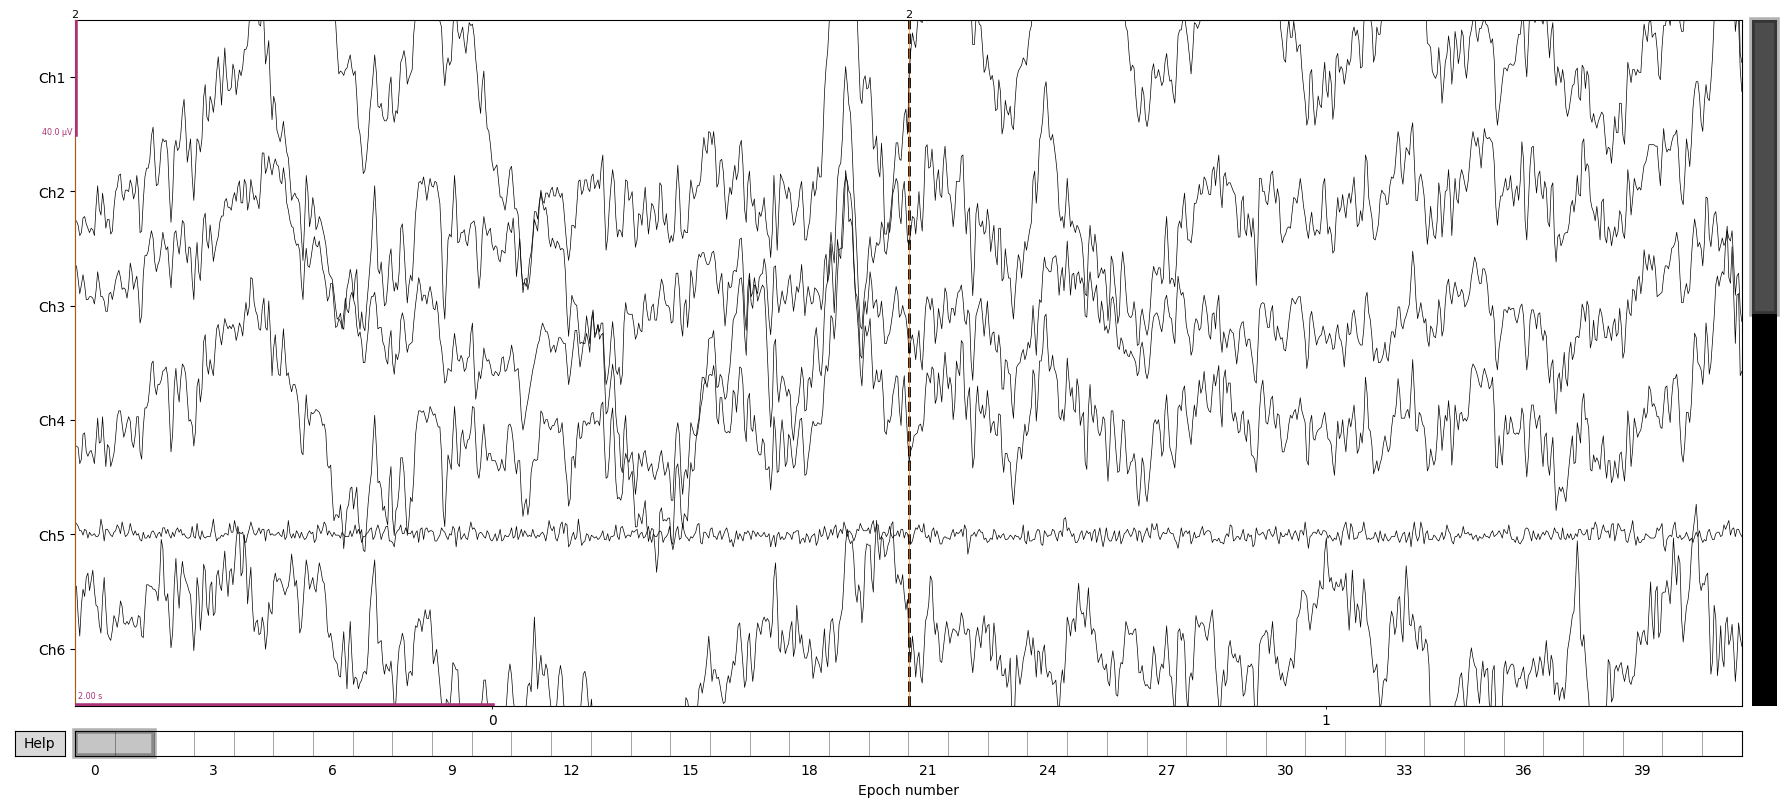

In [138]:
fig = epochs.plot(n_epochs=2, n_channels=6, events=True)